# Import library

In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
tqdm_notebook.pandas(desc='PROGRESS>>>')

# About the data

The data here is the survey responses that we collected from TINYpulse system for the question "How happy are you at work"

This question is a scale question with the score from 1 to 10 and user will give the score with the text responses for there thought on the score that they gave

Trying to use NLP by letting the machine learn about the score and response text, we are trying to build a model for TINYpulse system to predict the text response for only text question is negative, positive or neutral and we can reduce the time that a user need to pay attention to read all the response text

**UPDATE**

Base on previous investigate and data review, we narrow the data into 1 category with most responses:
**Computer & Software** for **All** questions in **Culture** category

# Load CSV file

In [2]:
responses_df = pd.read_csv('ccs.csv', encoding="latin1")
responses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16225 entries, 0 to 16224
Data columns (total 3 columns):
submitted_at        16225 non-null object
response_integer    16225 non-null int64
response_text       16178 non-null object
dtypes: int64(1), object(2)
memory usage: 380.4+ KB


**some responses that have N/A value for question_response_more (user still answer the question with the score, but leave the comment with text N/A)**

In [3]:
responses_df[responses_df.response_text.isna()]

,submitted_at,response_integer,response_text
588,2017-01-30 11:39:38,9,NaN
2253,2017-03-08 18:25:19,3,NaN
3435,2017-04-20 18:49:38,1,NaN
4427,2017-02-20 13:45:32,9,NaN
4685,2017-06-14 17:23:11,10,NaN
4710,2017-06-15 00:55:39,10,NaN
4904,2017-08-14 18:38:27,10,NaN
4969,2017-08-14 18:49:42,5,NaN
5125,2017-10-18 10:00:21,10,NaN
5240,2017-11-23 15:59:11,9,NaN


We don't need those responses and it could affect the train model, so we cleaning it up

In [4]:
responses_df = responses_df.dropna()

In [5]:
score_distribution = responses_df['response_integer'].value_counts().sort_index()

In [6]:
score_distribution

1      693
2      535
3      924
4      857
5     1727
6     1538
7     2346
8     2844
9     2135
10    2579
Name: response_integer, dtype: int64

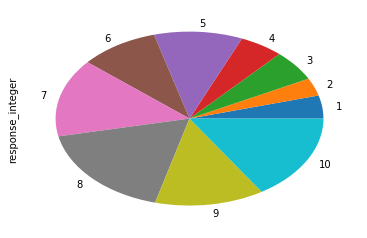

In [7]:
score_distribution.plot(kind='pie')

# Classify the response score into 3 type: 

- 1,2,3,4 -> Negative
- 5,6-> Neutral
- 7,8,9,10 -> Positive

In [8]:
def sentiment_score(score):
    if score < 5:
        return 1 #'negative'
    elif score > 6:
        return 0 #'positive'
    else:
        return 2 #'neutral'

In [9]:
responses_df['sentiment'] = responses_df['response_integer'].progress_apply(sentiment_score)

In [10]:
responses_df.head(10)

,submitted_at,response_integer,response_text,sentiment
0,2017-10-10 23:58:05,6,I'm not sure about other team; but my team doe...,2
1,2017-11-13 03:56:38,7,Got a lot of very talented engineers. We still...,0
2,2018-01-09 03:26:55,7,I can always do a better job of giving off bet...,0
3,2018-01-03 01:47:36,9,âI love to work here; I donât want to find...,0
4,2018-01-02 22:26:01,8,Attitude is a little thing that makes a big di...,0
5,2018-01-02 22:42:33,7,Feedback is usually positive for my work and I...,0
6,2017-10-16 09:12:18,4,I don't think we have retrospectives anymore.....,1
7,2017-10-11 03:08:58,5,Attach retrospective as a mandatory item in ev...,2
8,2017-11-13 09:23:04,6,I think our company has much thing to improve;...,2
9,2017-11-21 10:37:18,8,Really big freedom and more accountability,0


# Take a look with the sentiment:

In [11]:
responses_df['sentiment'].value_counts().sort_index()

0    9904
1    3009
2    3265
Name: sentiment, dtype: int64

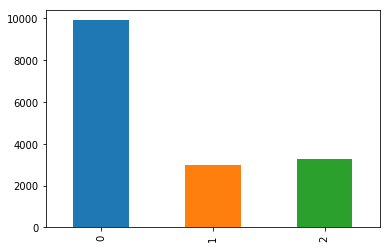

In [12]:
responses_df['sentiment'].value_counts().sort_index().plot(kind='bar')

**Look like the number of `Negative` responses is quite small, it could affect the training for predicting the Negative, but keep going with the input data, we will improve the data input later**

**_TODO_**: Increase the response with `Negative` value, so that the model could recognize the `Negative` response better (**we hope**)

**Result**: We tried to classify the Negative, Positive and Neutral value of a response by looking at the chart and the distribution of score value:
* At the first time, we try to balance the number of response in Neg, Pos and Neu, but the accuracy is going down:
 * 9,10 -> Positive
 * 6,7,8 -> Neutral
 * 1,2,3,4,5 -> Negative

* Then we try to increase the Neutral value, and balance for the Positive and Negative that mean we have more neutral response, but the accuracy value is not increased:
 * 9,10 -> Positive
 * 5,6,7,8 -> Neutral
 * 1,2,3,4 -> Negative

**Getting the dataframe for processing data:**

In [13]:
nlp_df = responses_df[['response_text', 'sentiment']]

In [14]:
nlp_df.head(20)

,response_text,sentiment
0,I'm not sure about other team; but my team doe...,2
1,Got a lot of very talented engineers. We still...,0
2,I can always do a better job of giving off bet...,0
3,âI love to work here; I donât want to find...,0
4,Attitude is a little thing that makes a big di...,0
5,Feedback is usually positive for my work and I...,0
6,I don't think we have retrospectives anymore.....,1
7,Attach retrospective as a mandatory item in ev...,2
8,I think our company has much thing to improve;...,2
9,Really big freedom and more accountability,0


**Using regular expression to remove not alphabet character, by replacing them with space character:**

In [15]:
import re
first_text=nlp_df.response_text[71]
text=re.sub("[^a-zA-Z]"," ",first_text) #changing characters with space
text=text.lower()

In [16]:
def preprocessor(text):
    result=re.sub("[^a-zA-Z]"," ",text) #changing characters with space
    result=result.lower()
    return result

**Lets review of changing:**

In [17]:
print(nlp_df.response_text[0])
text = preprocessor(nlp_df.response_text[0]) 
print(text)

I'm not sure about other team; but my team doesn't has retrospectives.
i m not sure about other team  but my team doesn t has retrospectives 


### Stopwords

In [18]:
#stopwords (irrelavent words)
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khuyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/khuyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/khuyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
def tokenizer(text):
    return nltk.word_tokenize(text)

In [20]:
tokenizer(text)

['i',
 'm',
 'not',
 'sure',
 'about',
 'other',
 'team',
 'but',
 'my',
 'team',
 'doesn',
 't',
 'has',
 'retrospectives']

### Lemmatization
ex: employees --> employee

In [21]:
import nltk as nlp
lemma=nlp.WordNetLemmatizer()

In [22]:
def tokenizer_porter(text):
    result = [lemma.lemmatize(word) for word in tokenizer(text)]
    return result

In [23]:
tokenizer_porter(text)

['i',
 'm',
 'not',
 'sure',
 'about',
 'other',
 'team',
 'but',
 'my',
 'team',
 'doesn',
 't',
 'ha',
 'retrospective']

comparing all steps

In [24]:
print(text)
print(preprocessor(text))
print(" ".join(tokenizer(text)))
print(" ".join(tokenizer_porter(text)))

i m not sure about other team  but my team doesn t has retrospectives 
i m not sure about other team  but my team doesn t has retrospectives 
i m not sure about other team but my team doesn t has retrospectives
i m not sure about other team but my team doesn t ha retrospective


## Applying tokenize and lemmatize for all response text

In [25]:
text_list=[]
for resp in nlp_df.response_text:
    result = preprocessor(resp)
    result = tokenizer_porter(result)
    result = " ".join(result)
    text_list.append(result)

In [26]:
text_list[:10]

['i m not sure about other team but my team doesn t ha retrospective',
 'got a lot of very talented engineer we still need more discipline around process and product quality',
 'i can always do a better job of giving off better energy i think by nature i m a bit low key and can be lethargic at time so it s a real effort to show high energy for me',
 'i love to work here i don t want to find another company again ahihi',
 'attitude is a little thing that make a big difference',
 'feedback is usually positive for my work and i feel like most of my interaction with teammate are also positive',
 'i don t think we have retrospective anymore at least our team hasn t had any for a few month now',
 'attach retrospective a a mandatory item in every sprint planning and follow action item to the end i can see day by day we are losing enthusiasm to raise concern it s better to build habit for team member to raise their voice whenever they have thing need to be improved instead of thought what will

## bag of words

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=400000
cou_vec=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=cou_vec.fit_transform(text_list).toarray()
all_words=cou_vec.get_feature_names()
print("Most used words: ", all_words[0:100])

Most used words:  ['aa', 'aad', 'aaron', 'ab', 'abandoned', 'abbreviate', 'abc', 'aber', 'abide', 'abiity', 'ability', 'abismal', 'able', 'abnormal', 'abo', 'abraham', 'abreast', 'abroad', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley', 'absorb', 'absorbed', 'absorbing', 'abstract', 'abstracted', 'abstraction', 'absurd', 'abundant', 'abuse', 'abused', 'abusing', 'abusive', 'abysmal', 'abysmally', 'ac', 'academic', 'academy', 'accelerate', 'accelerated', 'accelerating', 'accelerator', 'accept', 'acceptable', 'acceptance', 'acceptanve', 'accepted', 'accepting', 'acces', 'access', 'accessed', 'accessibility', 'accessible', 'accessing', 'accessonecloud', 'accessviewpoint', 'accident', 'accidentally', 'accidently', 'acclimate', 'accommodate', 'accommodating', 'accommodation', 'accomodate', 'accomodating', 'accomodation', 'accomplish', 'accomplished', 'accomplishes', 'accomplishing', 'accomplishment', 'accord', 'accordance', 'according', 'acco

Now we have the sparce matrix and vectorize all the response text

## Visualize the words with wordcloud

In [28]:
from wordcloud import WordCloud

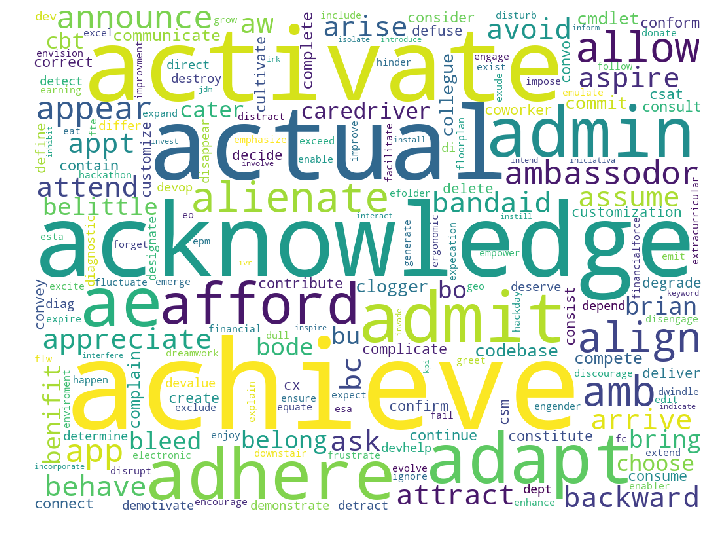

In [29]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(all_words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Splitting test for building model and test

In [30]:
y=nlp_df.iloc[:,1].values
x=sparce_matrix
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

## Random Forest:

In [31]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(x_train,y_train)
print("accuracy: ",rf.score(x_test,y_test))

/Users/khuyen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


accuracy:  0.6081582200247219


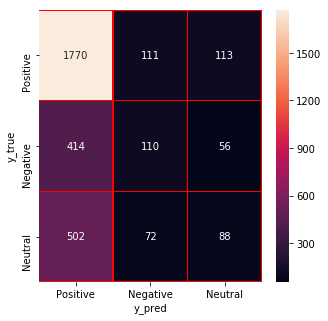

In [32]:
#confussion matrix
y_pred=rf.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
print("lr accuracy: ",lr.score(x_test,y_test))

lr accuracy:  0.6263906056860321


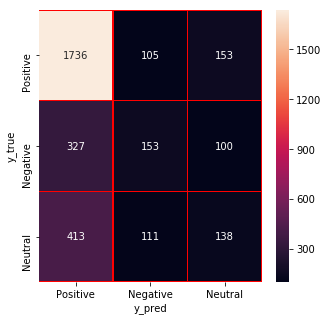

In [34]:
#confussion matrix
y_pred=lr.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [35]:
print("Text Size: ", len(x_test))

Text Size:  3236


**Test Size = 3236**
Predict False Positives:
- Negative -> Positive : 327
- Negative -> Neutral : 100

**%False Positives in dangerous zone :**

In [36]:
(100+327)/len(x_test)

0.13195302843016068

**~13.2%**

**So, we are safe for predict with the text with acceptable percentage = 100 - 13.2 = 86.8%**

**We can use the trained model for predicting the text question which have the meaning similar to happiness question**

# OK, so we choose Logistic Regression test for our Model
Let do it probably for a model that can be reused

**Now we make a model which can predict text with Logistic Regression**

In [37]:
from sklearn.pipeline import Pipeline

## **1 Changing for bulding the model here**

Instead of using `CountVectorizer`, I'm now using `TfidfVectorizer`

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'),
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)

In [39]:
max_features = 400000
cou_vec = CountVectorizer(max_features=max_features,
                            stop_words=stopwords.words('english'),
                            tokenizer=tokenizer_porter,
                            preprocessor=preprocessor)

In [40]:
clf = Pipeline([('vect', cou_vec),
                ('clf', LogisticRegression(random_state=0))])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(nlp_df['response_text'], 
                                                    nlp_df['sentiment'], test_size = 0.2, random_state = 42)

In [42]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=400000, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function preprocessor at ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [43]:
print('Test Size: ', len(X_test))

Test Size:  3236


Recheck for what we did

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [45]:
predictions = clf.predict(X_test)

In [46]:
print ('Accuracy:', accuracy_score(y_test, predictions))
print('Clasification Report:\n', classification_report(y_test, predictions))

Accuracy: 0.6285537700865266
Clasification Report:
              precision    recall  f1-score   support

          0       0.70      0.87      0.78      1994
          1       0.43      0.29      0.35       580
          2       0.34      0.19      0.25       662

avg / total       0.58      0.63      0.59      3236



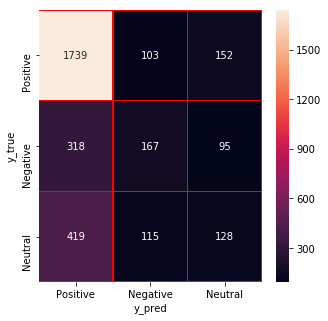

In [47]:
cm = confusion_matrix(y_test, predictions)
f,ax=plt.subplots(figsize=(5,5))
names=["Positive","Negative","Neutral"]
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

**%False Positives in dangerous zone :**

In [48]:
(318+95)/len(X_test)

0.1276266996291718

**12.7%, LOOK GOOOOOD**

In [49]:
preds = clf.predict_proba(['I would recommend the Associated Recreation Council. https://www.arcseattle.orgThey are the non-profit that partners with Seattle Parks and Recreation that attempts to inspire engagement and remove barriers to access so the entire community can learn; play and grow through quality programs in a safe; welcoming environment. They handle funding for environmental stewardship; sports; lifelong recreation; youth programs and summer day camps with community centers; environmental education centers and parks.'])

In [50]:
preds

array([[0.0423566 , 0.32171986, 0.63592354]])

**Trying with TINYpulse API service**

In [51]:
def predict_value_text(predict_values):
    text = ['postive', 'negative', 'neutral']
    max_value = max(predict_values)
    idx = predict_values.tolist().index(max_value)
    return text[idx]

In [52]:
import requests

In [55]:
resp = requests.get('https://api.tinypulse.com/pulse/v1/surveys/326212/responses', 
                    headers={'AccessToken': 'h2925gprdzyfm4hfc78f'})
responses_text = []
if resp.status_code == 200:
    data = resp.json()['data']
    for response in data:
        responses_text.append(str(response['attributes']['response_text']))

predict_result = clf.predict_proba(responses_text)

for idx, text in enumerate(responses_text):
    predict_values =  predict_result[idx]
    print("{} ---------------------\n{}\n\nPREDICT: {}".format(idx, text, predict_value_text(predict_values)))

0 ---------------------
base on my experience on past large size cloud products. The production should delay for at least 1 development sprint (2 weeks) for stabilization from master. The size of current TINYpulse projects are not big enough to face problems but day by day, they will bigger & bigger and the QA pressure to keep production up-to-date with master is huge.

PREDICT: negative
1 ---------------------
Hey, I'm happy with current company processes in general so please keep it as it is (or, maybe I'm new and haven't gone through much of company processes to be able to give much more meaningful feedback).

Cheer.

PREDICT: postive
2 ---------------------
Nothing

PREDICT: postive
3 ---------------------
I think we should have a better plan. Many tasks are suddenly added in between the sprint with high priority.

PREDICT: neutral
4 ---------------------
I'm happy with our current processes.

PREDICT: postive
5 ---------------------
.

PREDICT: postive
6 ---------------------
UI d

In [54]:
print("\n\n\n**PREDICTION RESULT**\n\n\n")
for idx, value in enumerate(predict_result):
    print("{} : {}".format(idx, value))




**PREDICTION RESULT**



0 : [0.23477374 0.64632861 0.11889765]
1 : [0.27567424 0.04672493 0.67760083]
2 : [0.33485505 0.57640726 0.08873769]
3 : [0.97432624 0.01053405 0.01513971]
4 : [0.71852725 0.07746571 0.20400704]
5 : [0.81158021 0.02903591 0.15938388]
6 : [0.8476242  0.07062182 0.08175398]
7 : [0.65906481 0.16782914 0.17310605]
8 : [0.15490834 0.21109705 0.63399461]
9 : [0.45684238 0.00057577 0.54258184]
10 : [7.33784009e-01 5.05642813e-04 2.65710348e-01]
11 : [0.63814228 0.19308777 0.16876995]
12 : [0.2722089  0.19120846 0.53658263]
13 : [0.71092702 0.06756871 0.22150427]
14 : [0.4714682  0.3261392  0.20239259]
15 : [0.62198371 0.22211939 0.1558969 ]
16 : [0.96100868 0.02134958 0.01764174]
17 : [0.67163654 0.19370419 0.13465926]
18 : [0.48843487 0.29431585 0.21724929]
19 : [0.75612514 0.1647498  0.07912507]
20 : [0.35385474 0.59621208 0.04993318]
21 : [0.44749777 0.34429879 0.20820344]
22 : [0.94908841 0.02108754 0.02982405]
23 : [0.85350848 0.00375059 0.14274093]
